## This is only for the experiments which is incorrect verification for negative samples.
Targets: experiments before 2024/03/11

In [2]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np

## example

```bash
nohup parallel 'python3 experiment_dbpedia_14.py --group_id dbpedia_14_20240109 --n_sample_from 5 --n_sample_to 25 --n_trials 10 --verification {1} --strategy {2}' ::: themselves dataset ::: normal super > results/ex_20240109.log &

In [3]:
# group_id_list = ["truthfulqa_20240311"]
# group_id_list = ["triviaqa_20240213"]
group_id_list = ["dbpedia_14_20240109", "dbpedia_14_20240110"]
# load result
results = []
for group_id in group_id_list:
    result_files = glob.glob(f"./results/{group_id}/*.pickle")
    for file in result_files:
        with open(file, "rb") as f:
            tmp = pickle.load(f)
            # print("verification: ", tmp["args"].verification)
            # print("strategy: ", tmp["args"].strategy)
            # if tmp["args"].strategy == "normal":
            #     results.append(tmp)
            results.append(tmp)

# create plots folder
os.makedirs(f"./plots/{group_id_list[0]}/", exist_ok=True)

print(len(results[0]))

5


In [4]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "#samples", "n_trials", "strategy", "verification", "n_data", "dataset"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    if "dataset" in args:
        dataset = args.dataset
    else:
        dataset = ""
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    verification = args.verification
    if r.get("topics_dict"):
        topics_dict = r["topics_dict"]
        print(f"#topics/#items: {len(topics_dict)}/{sum([len(topics_dict[k]) for k in topics_dict.keys()])}")
        print(f"most frequent topic: {max(topics_dict, key=lambda x: len(topics_dict[x]))}, {len(topics_dict[max(topics_dict, key=lambda x: len(topics_dict[x]))])} items")
        print(f"average #items: {sum([len(topics_dict[k]) for k in topics_dict.keys()])/len(topics_dict)}")
    else:
        topics_dict = {}
    # if args.verification == "themselves" or strategy == "normal":
    #     continue
    for trial in r["result"]:
        for sample in trial:
            if topics_dict == {}:
                n_data = 1
            else:
                n_data = len(topics_dict[sample["class label"]])
            # need to swap FN and FP, so re-calculating accuracy.
            accuracy = (sample["TP"] + sample["FN"]) / (sample["TP"] + sample["TN"] + sample["FP"] + sample["FN"])
            df_data.append([
                model,
                sample["class label"],
                accuracy,
                sample["precision"],
                sample["TP"],
                sample["FN"],   # FN and FP are swapped
                sample["FP"],
                sample["TN"],   # FN and FP are swapped
                sample["n_samples"],
                n_trials,
                strategy,
                verification,
                n_data,
                dataset,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
# print("total #data should be:", 14*n_trials*5)
print(df_results.loc[0:14])

#data:  0
experiment settings:  Namespace(group_id='dbpedia_14_20240109', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='super', verification='dataset')
#data:  509
experiment settings:  Namespace(group_id='dbpedia_14_20240109', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='super', verification='themselves')
#data:  1187
experiment settings:  Namespace(group_id='dbpedia_14_20240109', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='normal', verification='dataset')
#data:  1848
experiment settings:  Namespace(group_id='dbpedia_14_20240110', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='normal', verificatio

In [5]:
def table_summary(df: DataFrame, is_print=True):
    # group by n_sample
    res_g_sample = df.groupby(by=["#samples"], as_index=False)
    w_avg = res_g_sample.apply(
        lambda row: np.average(row[["accuracy"]], axis=0, weights=row["n_data"])
    )
    w_prec = res_g_sample.apply(
        lambda row: np.average(row[["precision"]], axis=0, weights=row["n_data"])
    )
    w_avg = pd.concat([pd.Series(res_g_sample["#samples"].groups.keys()), w_avg, w_prec], axis=1)
    w_avg.columns = [ "#samples", "accuracy", "precision"]
    w_avg = w_avg.explode(['accuracy', 'precision']).reset_index(drop=True)
    cor = w_avg[['#samples', 'accuracy', 'precision']].corr()
    
    # res_g_sample = res_g_sample.drop(columns=["n_trials"])
    d_summary = res_g_sample.mean(["precision", "accuracy", "TP", "TN", "FP", "FN"])
    if is_print:
        print(d_summary.drop(columns=["n_trials", "n_data"]).to_latex(escape=True,index=False))
        print(w_avg.to_latex(escape=True, index=False))
        print(cor.to_latex(escape=True))
    return d_summary, w_avg, cor

In [6]:
d = df_results[df_results["strategy"] == "normal"]
d = d[d["verification"] == "dataset"]
table_summary(d)

\begin{tabular}{rrrrrrr}
\toprule
\#samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.515942 & 0.704348 & 3.521739 & 1.637681 & 1.478261 & 3.362319 \\
10 & 0.471269 & 0.632836 & 6.328358 & 3.097015 & 3.671642 & 6.902985 \\
15 & 0.452840 & 0.622222 & 9.333333 & 4.251852 & 5.666667 & 10.748148 \\
20 & 0.438953 & 0.588760 & 11.775194 & 5.782946 & 8.224806 & 14.217054 \\
25 & 0.413280 & 0.581440 & 14.536000 & 6.128000 & 10.464000 & 18.872000 \\
\bottomrule
\end{tabular}

\begin{tabular}{rll}
\toprule
\#samples & accuracy & precision \\
\midrule
5 & 0.515942 & 0.704348 \\
10 & 0.471269 & 0.632836 \\
15 & 0.452840 & 0.622222 \\
20 & 0.438953 & 0.588760 \\
25 & 0.413280 & 0.581440 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & \#samples & accuracy & precision \\
\midrule
\#samples & 1.000000 & -0.976562 & -0.937000 \\
accuracy & -0.976562 & 1.000000 & 0.976545 \\
precision & -0.937000 & 0.976545 & 1.000000 \\
\bottomrule
\end{tabular}


(   #samples  accuracy  precision         TP        TN         FP         FN  \
 0         5  0.515942   0.704348   3.521739  1.637681   1.478261   3.362319   
 1        10  0.471269   0.632836   6.328358  3.097015   3.671642   6.902985   
 2        15  0.452840   0.622222   9.333333  4.251852   5.666667  10.748148   
 3        20  0.438953   0.588760  11.775194  5.782946   8.224806  14.217054   
 4        25  0.413280   0.581440  14.536000  6.128000  10.464000  18.872000   
 
    n_trials  n_data  
 0      10.0     1.0  
 1      10.0     1.0  
 2      10.0     1.0  
 3      10.0     1.0  
 4      10.0     1.0  ,
    #samples  accuracy precision
 0         5  0.515942  0.704348
 1        10  0.471269  0.632836
 2        15   0.45284  0.622222
 3        20  0.438953   0.58876
 4        25   0.41328   0.58144,
            #samples  accuracy  precision
 #samples   1.000000 -0.976562  -0.937000
 accuracy  -0.976562  1.000000   0.976545
 precision -0.937000  0.976545   1.000000)

In [7]:
d = df_results[df_results["strategy"] == "normal"]
d = d[d["verification"] == "themselves"]
table_summary(d)

\begin{tabular}{rrrrrrr}
\toprule
\#samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.905797 & 0.828986 & 4.144928 & 4.913043 & 0.855072 & 0.086957 \\
10 & 0.839695 & 0.703053 & 7.030534 & 9.763359 & 2.969466 & 0.236641 \\
15 & 0.812745 & 0.652451 & 9.786765 & 14.595588 & 5.213235 & 0.404412 \\
20 & 0.783942 & 0.597810 & 11.956204 & 19.401460 & 8.043796 & 0.598540 \\
25 & 0.785778 & 0.612444 & 15.311111 & 23.977778 & 9.688889 & 1.022222 \\
\bottomrule
\end{tabular}

\begin{tabular}{rll}
\toprule
\#samples & accuracy & precision \\
\midrule
5 & 0.905797 & 0.828986 \\
10 & 0.839695 & 0.703053 \\
15 & 0.812745 & 0.652451 \\
20 & 0.783942 & 0.597810 \\
25 & 0.785778 & 0.612444 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & \#samples & accuracy & precision \\
\midrule
\#samples & 1.000000 & -0.929964 & -0.912541 \\
accuracy & -0.929964 & 1.000000 & 0.998822 \\
precision & -0.912541 & 0.998822 & 1.000000 \\
\bottomrule
\end{tabular}


(   #samples  accuracy  precision         TP         TN        FP        FN  \
 0         5  0.905797   0.828986   4.144928   4.913043  0.855072  0.086957   
 1        10  0.839695   0.703053   7.030534   9.763359  2.969466  0.236641   
 2        15  0.812745   0.652451   9.786765  14.595588  5.213235  0.404412   
 3        20  0.783942   0.597810  11.956204  19.401460  8.043796  0.598540   
 4        25  0.785778   0.612444  15.311111  23.977778  9.688889  1.022222   
 
    n_trials  n_data  
 0      10.0     1.0  
 1      10.0     1.0  
 2      10.0     1.0  
 3      10.0     1.0  
 4      10.0     1.0  ,
    #samples  accuracy precision
 0         5  0.905797  0.828986
 1        10  0.839695  0.703053
 2        15  0.812745  0.652451
 3        20  0.783942   0.59781
 4        25  0.785778  0.612444,
            #samples  accuracy  precision
 #samples   1.000000 -0.929964  -0.912541
 accuracy  -0.929964  1.000000   0.998822
 precision -0.912541  0.998822   1.000000)

In [8]:
d = df_results[df_results["strategy"] == "super"]
d = d[d["verification"] == "dataset"]
table_summary(d)

\begin{tabular}{rrrrrrr}
\toprule
\#samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.610476 & 0.693333 & 3.466667 & 2.638095 & 1.533333 & 2.361905 \\
10 & 0.604545 & 0.666364 & 6.663636 & 5.427273 & 3.336364 & 4.572727 \\
15 & 0.532051 & 0.594872 & 8.923077 & 7.038462 & 6.076923 & 7.961538 \\
20 & 0.506683 & 0.559406 & 11.188119 & 9.079208 & 8.811881 & 10.920792 \\
25 & 0.554607 & 0.608539 & 15.213483 & 12.516854 & 9.786517 & 12.483146 \\
\bottomrule
\end{tabular}

\begin{tabular}{rll}
\toprule
\#samples & accuracy & precision \\
\midrule
5 & 0.610476 & 0.693333 \\
10 & 0.604545 & 0.666364 \\
15 & 0.532051 & 0.594872 \\
20 & 0.506683 & 0.559406 \\
25 & 0.554607 & 0.608539 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & \#samples & accuracy & precision \\
\midrule
\#samples & 1.000000 & -0.733254 & -0.803003 \\
accuracy & -0.733254 & 1.000000 & 0.987772 \\
precision & -0.803003 & 0.987772 & 1.000000 \\
\bottomrule
\end{tabular}


(   #samples  accuracy  precision         TP         TN        FP         FN  \
 0         5  0.610476   0.693333   3.466667   2.638095  1.533333   2.361905   
 1        10  0.604545   0.666364   6.663636   5.427273  3.336364   4.572727   
 2        15  0.532051   0.594872   8.923077   7.038462  6.076923   7.961538   
 3        20  0.506683   0.559406  11.188119   9.079208  8.811881  10.920792   
 4        25  0.554607   0.608539  15.213483  12.516854  9.786517  12.483146   
 
    n_trials  n_data  
 0      10.0     1.0  
 1      10.0     1.0  
 2      10.0     1.0  
 3      10.0     1.0  
 4      10.0     1.0  ,
    #samples  accuracy precision
 0         5  0.610476  0.693333
 1        10  0.604545  0.666364
 2        15  0.532051  0.594872
 3        20  0.506683  0.559406
 4        25  0.554607  0.608539,
            #samples  accuracy  precision
 #samples   1.000000 -0.733254  -0.803003
 accuracy  -0.733254  1.000000   0.987772
 precision -0.803003  0.987772   1.000000)

In [9]:
d = df_results[df_results["strategy"] == "super"]
d = d[d["verification"] == "themselves"]
table_summary(d)

\begin{tabular}{rrrrrrr}
\toprule
\#samples & accuracy & precision & TP & TN & FP & FN \\
\midrule
5 & 0.671014 & 0.820290 & 4.101449 & 2.608696 & 0.898551 & 2.391304 \\
10 & 0.647810 & 0.673723 & 6.737226 & 6.218978 & 3.262774 & 3.781022 \\
15 & 0.607246 & 0.647343 & 9.710145 & 8.507246 & 5.289855 & 6.492754 \\
20 & 0.614179 & 0.585448 & 11.708955 & 12.858209 & 8.291045 & 7.141791 \\
25 & 0.650382 & 0.609771 & 15.244275 & 17.274809 & 9.755725 & 7.725191 \\
\bottomrule
\end{tabular}

\begin{tabular}{rll}
\toprule
\#samples & accuracy & precision \\
\midrule
5 & 0.671014 & 0.820290 \\
10 & 0.647810 & 0.673723 \\
15 & 0.607246 & 0.647343 \\
20 & 0.614179 & 0.585448 \\
25 & 0.650382 & 0.609771 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & \#samples & accuracy & precision \\
\midrule
\#samples & 1.000000 & -0.443444 & -0.875335 \\
accuracy & -0.443444 & 1.000000 & 0.708753 \\
precision & -0.875335 & 0.708753 & 1.000000 \\
\bottomrule
\end{tabular}


(   #samples  accuracy  precision         TP         TN        FP        FN  \
 0         5  0.671014   0.820290   4.101449   2.608696  0.898551  2.391304   
 1        10  0.647810   0.673723   6.737226   6.218978  3.262774  3.781022   
 2        15  0.607246   0.647343   9.710145   8.507246  5.289855  6.492754   
 3        20  0.614179   0.585448  11.708955  12.858209  8.291045  7.141791   
 4        25  0.650382   0.609771  15.244275  17.274809  9.755725  7.725191   
 
    n_trials  n_data  
 0      10.0     1.0  
 1      10.0     1.0  
 2      10.0     1.0  
 3      10.0     1.0  
 4      10.0     1.0  ,
    #samples  accuracy precision
 0         5  0.671014   0.82029
 1        10   0.64781  0.673723
 2        15  0.607246  0.647343
 3        20  0.614179  0.585448
 4        25  0.650382  0.609771,
            #samples  accuracy  precision
 #samples   1.000000 -0.443444  -0.875335
 accuracy  -0.443444  1.000000   0.708753
 precision -0.875335  0.708753   1.000000)

In [10]:
def plot_acc_prec_summary(df: DataFrame, fontsize=12, target=["accuracy"], compare_with={}, figsize=(16, 8)):
    # df_target = df.groupby(by=["strategy", "#samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1)
    # plt.title(f"{model}")
    plt.xlabel("#samples", fontsize=fontsize)
    plt.ylabel("/".join(target), fontsize=fontsize)
    plt.ylim(0, 1.05)
    
    # accuracy should be weighted by n_data
    labels = []
    for idx, (l, klass) in enumerate(df_target.groupby(by="strategy")):
        # subplt = plt.subplot(1, 2, idx+1)
        # subplt.set_title(l, fontsize=fontsize)
        # subplt.set_ylim(0, 1.05)
        # subplt.set_xlabel("#samples", fontsize=fontsize)

        plot_data = {}
        n_list = []
        for n_sample, data in klass.groupby(by="#samples"):
            n_list.append(n_sample)
            for t in target:
                weighted = np.average(data[t], weights=data["n_data"])
                plot_data[t] = plot_data.get(t, []) + [weighted]
        for t in target:
            plt.plot(n_list, plot_data[t], label=f"{t} - {l}")
        plt.xticks(n_list)
        plt.xlim(min(n_list)-1, max(n_list)+1)
    if compare_with != {}:
        for k, v in compare_with.items():
            plt.axhline(y=v, color="gray", linestyle="--", label=f"{k} ({v})")
    
    # plt.title("accuracy", fontsize=fontsize)
    # plt.ylabel("accuracy", fontsize=fontsize)
    # 
    # precs_by_n_sample = []
    # accs_by_n_sample = []
    # n_list = []
    # for n_sample, data in df.groupby(by="#samples"):
    #     n_list.append(n_sample)
    #     precs_by_n_sample.append(data["precision"].mean())
    #     accs_by_n_sample.append(data["accuracy"].mean())
    # plt.plot(n_list, precs_by_n_sample, label="precision")
    # plt.plot(n_list, accs_by_n_sample, label="accuracy")
    # plt.xticks(n_list)

    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2, fontsize=fontsize)
    # save images
    plt.savefig(f"./plots/{group_id_list[0]}/summary-{"-".join(target)}.pdf")

## Benchmark score on TruthfulQA dataset 
source: [https://github.com/sylinrl/truthfulqa](https://github.com/sylinrl/truthfulqa)

### %true
InstructGPT: 0.48

Comparable with precision
precisionはTN, FNを用いないため，負例ピックアップstrategyによる差がない(比較する意味がない)．
しかし，検証時のtemperatureのランダム性によって，precisionが変動する．


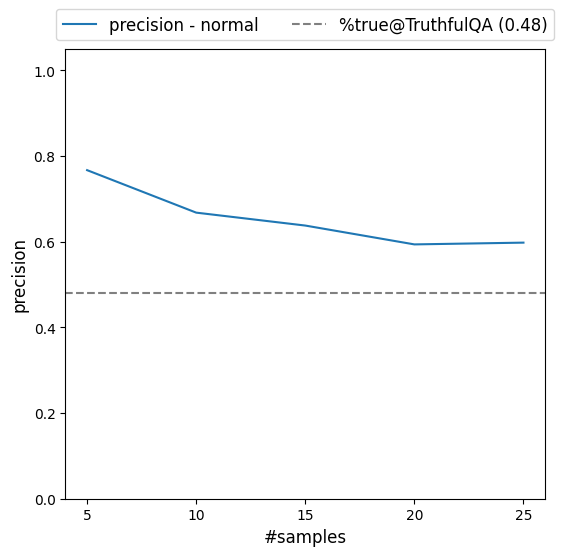

In [11]:
df_results_normal = df_results[df_results["strategy"] == "normal"]
plot_acc_prec_summary(df_results_normal, fontsize=12, target=["precision"], compare_with={"%true@TruthfulQA":0.48}, figsize=(6, 6))

## TruthfulQA dataset
### MC1
Comparable with Accuracy

InstructGPT: 


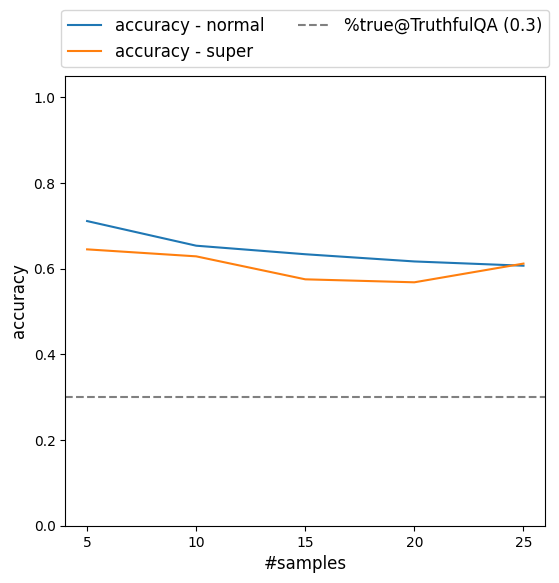

In [12]:
plot_acc_prec_summary(df_results, fontsize=12, target=["accuracy"], compare_with={"%true@TruthfulQA":0.3}, figsize=(6, 6))

In [13]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, strategy="normal", verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "#samples", "label"], as_index=False)
    df_target = df[df["strategy"] == strategy]
    df_target = df_target[df_target["verification"] == verification]
    print(f"# target data: {len(df_target)}")
    # plot
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.1, right=0.95, top=0.75, bottom=0.1)
    # plt.set_cmap("tab20")
    cm = plt.get_cmap("tab20")
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("#samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    # sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("#samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    # sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("#samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0, 1.05)
    
    labels = []
    n_list = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        labels.append(l)
        for n_sample, data in klass.groupby(by="#samples"):
            n_list.append(n_sample)
            weighted_acc = np.average(data["accuracy"], weights=data["n_data"])
            weighted_prec = np.average(data["precision"], weights=data["n_data"])
            precs_by_n_sample.append(weighted_prec)
            accs_by_n_sample.append(weighted_acc)
        sub_prec.plot(n_list, precs_by_n_sample, label=l, color=cm(labels.index(l)))
        sub_acc.plot(n_list, accs_by_n_sample, label=l, color=cm(labels.index(l)))
    # plt.xticks(n_list)
    plt.legend(labels, loc="lower center", bbox_to_anchor=(0, 1), ncol=3, fontsize=fontsize-4)
    
    # save images
    fname = f"./plots/{group_id_list[0]}/{strategy}-{verification}-{ex_id}.pdf"
    plt.savefig(fname)
    print(f"saved: {fname}")

# target data: 661
saved: ./plots/dbpedia_14_20240109/normal-dataset-f45d86b98012ecdb668a02dda9c2204e.pdf


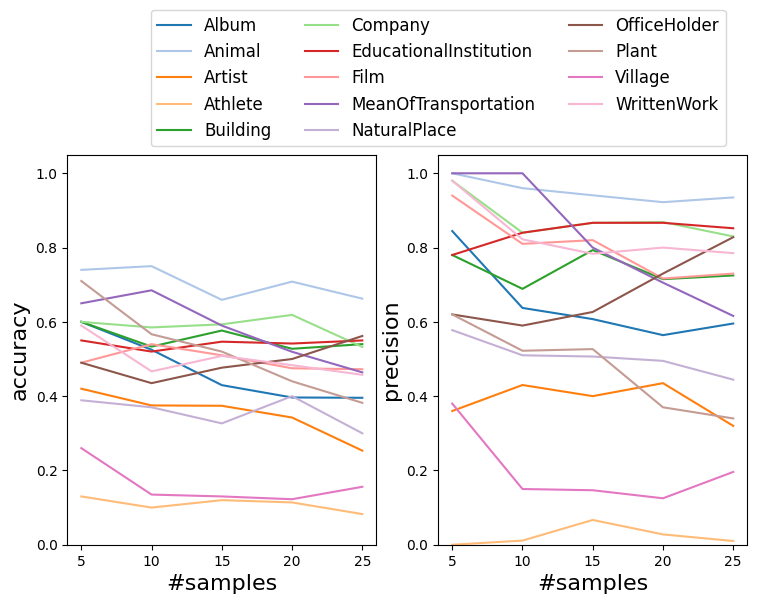

In [14]:
plot_acc_prec_by_verification(df_results, strategy="normal", verification="dataset", fontsize=16)

# target data: 677
saved: ./plots/dbpedia_14_20240109/normal-themselves-f45d86b98012ecdb668a02dda9c2204e.pdf


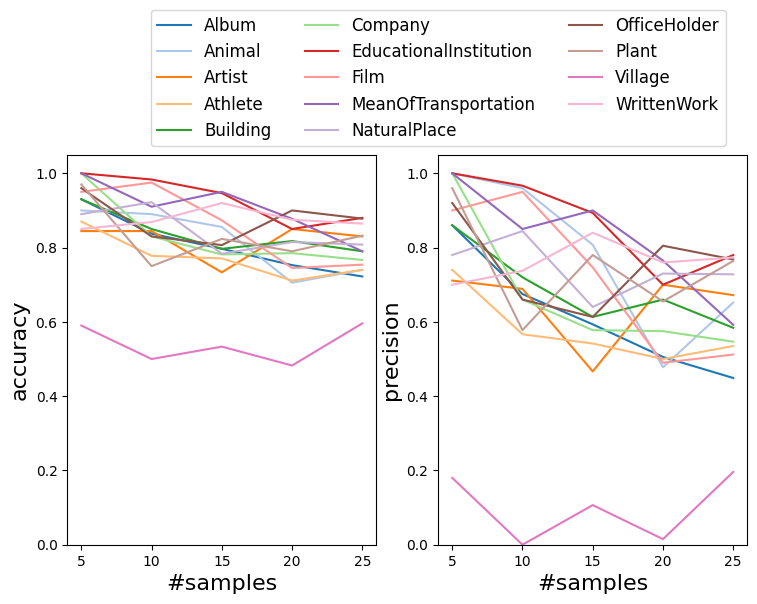

In [15]:
plot_acc_prec_by_verification(df_results, strategy="normal", verification="themselves", fontsize=16)

# target data: 509
saved: ./plots/dbpedia_14_20240109/super-dataset-f45d86b98012ecdb668a02dda9c2204e.pdf


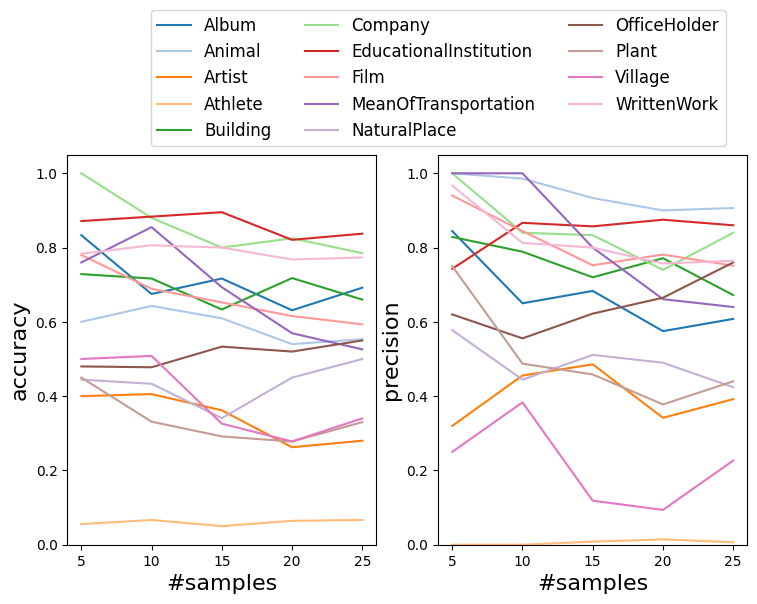

In [16]:
plot_acc_prec_by_verification(df_results, strategy="super", verification="dataset", fontsize=16)

# target data: 678
saved: ./plots/dbpedia_14_20240109/super-themselves-f45d86b98012ecdb668a02dda9c2204e.pdf


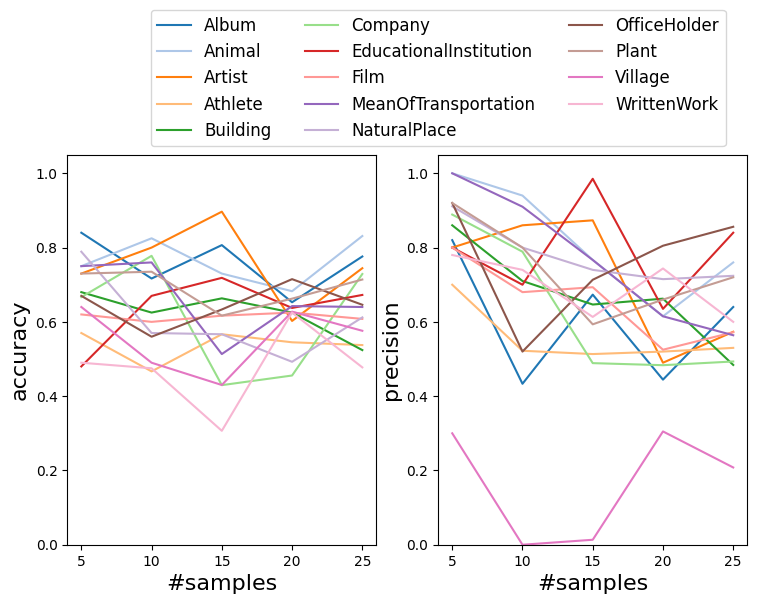

In [17]:
plot_acc_prec_by_verification(df_results, strategy="super", verification="themselves", fontsize=16)

In [45]:
from sklearn.metrics import confusion_matrix

def analyze_topics_by_metrics(df: DataFrame, metrics: str = "precision", compare = "verification", grand_truth = "", ranges_metrics: list[list[float]] = [[0, 0.3], [0.3, 0.6], [0.6, 1.0]]):
    # pick up data by strategy and verification
    res = {}
    for l, df_t in df.groupby(by=[compare]):
        means = df_t.groupby(by=["label"], as_index=False).mean([metrics])
        tmp = []
        for r in ranges_metrics:
            df_in_range = means[(means[metrics] > r[0]) & (means[metrics] <= r[1])]
            tmp.append(df_in_range["label"].values.tolist())
        res[l[0]] = tmp

    # compare items in the same range
    gt = res.pop(grand_truth)
    print(f"grand_truth: {gt}")
    flatten_gt = [item for sublist in gt for item in sublist]
    flatten_gt.sort()
    flatten_gt = {item:idx for idx, item in enumerate(flatten_gt)}
    # print(f"flatten_gt: {flatten_gt}")
    
    answer = []
    for label in flatten_gt:
        for i, l in enumerate(gt):
            if label in l:
                answer.append(i)
                break
    preds = {}        
    for tar, item in res.items():
        preds[tar] = []
        for label in flatten_gt:
            for i, l in enumerate(item):
                if label in l:
                    preds[tar].append(i)
                    break
    print(f"preds: {preds}")
    # print(f"answer: {answer}")
    n_items = len(flatten_gt)
    # print(f"#items: {n_items}")
    # class: range, item: label
    # analyze if classification of items in the same range is consistent
    # save results in dataframe
    columns = ["range", "TP", "TN", "accuracy", "precision"]
    result = []
    for r in res:
        print(f"{compare}: {r}")
        print(f"target: {res[r]}")
        print(f"confusion matrix: {confusion_matrix(answer, preds[r])}")
        for i in range(len(ranges_metrics)):
            # print(f"range: {ranges_metrics[i]}")
            TP = 0
            TN = 0
            for l in flatten_gt.keys():
                if l in gt[i]:
                    if l in res[r][i]:
                        TP += 1
                else:
                    if l not in res[r][i]:
                        TN += 1
            # print(f"TP: {TP}, TN: {TN}, accuracy: {(TP+TN)/n_items}, precision: {TP/(TP+TN)}, recall: {TP/len(gt[i])}, F1: {2*TP/(2*TP+TN+len(gt[i]))}")
            result.append([f"{ranges_metrics[i]}", TP, TN, (TP+TN)/n_items, TP/(TP+TN)])
    df_result = pd.DataFrame(result, columns=columns)
    print("")
    return df_result


def in_the_class(target, ranges: list[list]):
    for i, r in enumerate(ranges):
        if r[0] < target <= r[1]:
            return i


In [23]:
# ranges_prec = [[0, 0.25], [0.25, 0.5], [0.5, 0.75],[0.75, 1.0]]
# ranges_prec = [[0, 0.5], [0.5, 1.0]]
# ranges_acc = [[0, 0.5], [0.5, 1.0]]
ranges_prec = [[0, 0.5], [0.5, 0.75], [0.75, 1.0]]
ranges_acc = [[0, 0.5], [0.5, 0.75], [0.75, 1.0]]

In [53]:
# strategy: normal
df_target = df_results[df_results["strategy"] == "normal"]
df_target = df_target[df_target["#samples"] == 15]
res_by_prec = analyze_topics_by_metrics(df_target, metrics="precision", compare="verification", grand_truth="dataset", ranges_metrics=ranges_prec)

print("by precision")
print(res_by_prec.to_latex(escape=True, index=False))

res_by_acc = analyze_topics_by_metrics(df_target, metrics="accuracy", compare="verification", grand_truth="dataset", ranges_metrics=ranges_acc)

print("by accuracy")
print(res_by_acc.to_latex(escape=True, index=False))


res: {'themselves': [['Artist', 'Village'], ['Album', 'Athlete', 'Building', 'Company', 'Film', 'NaturalPlace', 'OfficeHolder'], ['Animal', 'EducationalInstitution', 'MeanOfTransportation', 'Plant', 'WrittenWork']]}
grand_truth: [['Artist', 'Athlete', 'Village'], ['Album', 'NaturalPlace', 'OfficeHolder', 'Plant'], ['Animal', 'Building', 'Company', 'EducationalInstitution', 'Film', 'MeanOfTransportation', 'WrittenWork']]
preds: {'themselves': [1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2]}
verification: themselves
target: [['Artist', 'Village'], ['Album', 'Athlete', 'Building', 'Company', 'Film', 'NaturalPlace', 'OfficeHolder'], ['Animal', 'EducationalInstitution', 'MeanOfTransportation', 'Plant', 'WrittenWork']]
confusion matrix: [[2 1 0]
 [0 3 1]
 [0 3 4]]

by precision
\begin{tabular}{lrrrr}
\toprule
range & TP & TN & accuracy & precision \\
\midrule
[0, 0.5] & 2 & 11 & 0.928571 & 0.153846 \\
[0.5, 0.75] & 3 & 6 & 0.642857 & 0.333333 \\
[0.75, 1.0] & 4 & 6 & 0.714286 & 0.400000 \\
\botto

In [48]:
# strategy: normal, verification: themselves
df_target = df_results[df_results["strategy"] == "super"]
res_by_prec = analyze_topics_by_metrics(df_results, metrics="precision", compare="verification", grand_truth="dataset", ranges_metrics=ranges_prec)

print("by precision")
print(res_by_prec.to_latex(escape=True, index=False))

res_by_acc = analyze_topics_by_metrics(df_results, metrics="accuracy", compare="verification", grand_truth="dataset", ranges_metrics=ranges_acc)

print("by accuracy")
print(res_by_acc.to_latex(escape=True, index=False))

res: {'themselves': [['Village'], ['Album', 'Artist', 'Athlete', 'Building', 'Company', 'Film', 'Plant', 'WrittenWork'], ['Animal', 'EducationalInstitution', 'MeanOfTransportation', 'NaturalPlace', 'OfficeHolder']]}
grand_truth: [['Artist', 'Athlete', 'NaturalPlace', 'Plant', 'Village'], ['Album', 'OfficeHolder'], ['Animal', 'Building', 'Company', 'EducationalInstitution', 'Film', 'MeanOfTransportation', 'WrittenWork']]
preds: {'themselves': [1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1]}
verification: themselves
target: [['Village'], ['Album', 'Artist', 'Athlete', 'Building', 'Company', 'Film', 'Plant', 'WrittenWork'], ['Animal', 'EducationalInstitution', 'MeanOfTransportation', 'NaturalPlace', 'OfficeHolder']]
confusion matrix: [[1 3 1]
 [0 1 1]
 [0 4 3]]

by precision
\begin{tabular}{lrrrr}
\toprule
range & TP & TN & accuracy & precision \\
\midrule
[0, 0.5] & 1 & 9 & 0.714286 & 0.100000 \\
[0.5, 0.75] & 1 & 5 & 0.428571 & 0.166667 \\
[0.75, 1.0] & 3 & 5 & 0.571429 & 0.375000 \\
\bottom